# Daily Motivation Quotes


## Business Understanding

In a world filled with daily challenges and responsibilities, staying motivated is essential for personal growth and well-being. This data science project is dedicated to curating and delivering a diverse collection of carefully selected quotes. These inspirational snippets, sourced from various outlets including historical figures, popular literature, and notable personalities, aim to provide a source of encouragement, reflection, and empowerment for individuals facing the hustle of everyday life.

#### Objectives:

The primary objectives of this project are as follows:
1.	Curate Inspirational Quotes:
Gather a diverse collection of quotes from the Good Reads website, which boasts an extensive compilation of quotes spanning various genres and themes.
2.	Daily Motivational Updates: Develop a system to provide users with daily updates featuring a thoughtfully chosen quote. These updates will cater to different areas of life, ensuring a comprehensive and relatable experience.
3.	Tag-based Grouping: Implement a categorization mechanism that tags each quote based on its thematic content. This grouping will enable users to easily identify quotes that resonate with their specific preferences or current situations.


## Data Understanding

•	Source quotes from the Good Reads website, exploring the wide array of authors and themes available.

•	Analyze the structure of the collected data, including metadata such as author names, publication dates, and associated tags.


In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import scrapy 
import zipfile

import string
#from pathlib import path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk import FreqDist
import plotly.express as px

from langdetect import detect
from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob



from my_functions import translate_to_english, preprocess_text, preprocesss_text, compress_tags, clean_text

### 3.	Data Preparation
After obtaining the data we intend to use, we wil now open it here and begin the data cleaning process before proceeding to analysis.

In [2]:
# Reading the data
quotes = pd.read_csv(r'data/Quotes.csv', index_col=0)

# Read new dataset. 
"""We will reaad it directly from the Zipfile"""
with zipfile.ZipFile('data/tweets data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    
#Read the data into a data frame
tweets = pd.read_csv(r'data/Tweets.csv')


In [3]:
quotes

,Author Name,Quote,Tags
0,Oscar Wilde,“Be yourself; everyone else is already taken.”...,"['attributed-no-source', 'be-yourself', 'gilbe..."
1,Marilyn Monroe,"“I'm selfish, impatient and a little insecure....","['attributed-no-source', 'best', 'life', 'love..."
2,Albert Einstein,“Two things are infinite: the universe and hum...,"['attributed-no-source', 'human-nature', 'humo..."
3,Frank Zappa,"“So many books, so little time.” ― F...","['books', 'humor']"
4,Marcus Tullius Cicero,“A room without books is like a body without a...,"['attributed-no-source', 'books', 'simile', 's..."
...,...,...,...
2995,"A.A. Milne,",“I'm not lost for I know where I am. But howev...,NaN
2996,Henry David Thoreau,“Dreams are the touchstones of our characters....,NaN
2997,"Cassandra Clare,",“Black hair and blue eyes are my favorite comb...,NaN
2998,"Nicholas Sparks,",“In times of grief and sorrow I will hold you ...,NaN


We observe that the tags column did not get all the tags for the quotes and we will need to fill them up or remove them if that will not be possible. 
Although removing them will really affect the number of quotes availabe for us to use, therefore removing them will be a last resort. 
We will attempt to fill them based on the author. 

In [4]:
# Checking actual number of missing values. 
quotes.isna().sum()

Author Name      0
Quote            0
Tags           502
dtype: int64

In [5]:
# checking contents of the quote column. 
quotes['Quote'][3]

'“So many books, so little time.”      ―      Frank Zappa'

It appears the quote column still kept the name of the author. We can redo the split again below. We also observe that the quotes have extra quotes that will remain after separating the name from the quote, that will need to be removed as well to only leave a single double quotation mark. 

In [6]:
#  Split the content after the hyphen (―) into 'quote' and 'author' columns
quotes[['quote', 'author']] = quotes['Quote'].str.split('―',  expand=True)

# Strip leading and trailing whitespaces from 'quote' and 'author' columns
quotes['quote'] = quotes['quote'].str.strip()
quotes['author'] = quotes['author'].str.strip()

# Drop the original 'Quote' column since we have extracted its contents
quotes.drop('Quote', axis=1, inplace=True)

In [7]:
nan = quotes[quotes['Tags'].isna()]

In [8]:
nan

,Author Name,Tags,quote,author
2498,"John Green,",NaN,“And then something invisible snapped insider ...,"John Green, Looking for Alaska"
2499,Aristotle,NaN,“Hope is a waking dream.”,Aristotle
2500,Annie Proulx,NaN,“You should write because you love the shape o...,Annie Proulx
2501,Bill Watterson,NaN,“I'm killing time while I wait for life to sho...,Bill Watterson
2502,Alex Haley,NaN,"“Either you deal with what is the reality, or ...",Alex Haley
...,...,...,...,...
2995,"A.A. Milne,",NaN,“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh"
2996,Henry David Thoreau,NaN,“Dreams are the touchstones of our characters.”,Henry David Thoreau
2997,"Cassandra Clare,",NaN,“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel"
2998,"Nicholas Sparks,",NaN,“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook"


In [9]:
# preview the changes
quotes['quote'][53]

"“If you don't stand for something you will fall for anything.”"

In [10]:
quotes.groupby('Author Name').sum()

,Tags,quote,author
Author Name,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...
جلال الدين الرومي,0,“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي
عباس محمود العقاد,0,“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني


Checking the distribution of the authors and their quotes, we realize that some of them are not actually in english and this would affect the outcome of our code when filling the nan tags. we therefore need to translate them to English before preprocessing them for the fill. 
we can do that using the langdetect package available  in python together with googletrans package. 
we will install them using Pip then restart kernel and import them with the other packages.

Next, we will write a function that will do the translation for us called translate to english that is available in out my functions file. 

In [11]:
# Apply the translation function from my function file to the quote column
#quotes['quote_2'] = quotes['quote'].apply(translate_to_english)


Below we will also apply the translate to english function on the author column to have the names in English. the following codes really took a long time running on my local machine, therefore, I opted to run them using cloud services, i.e. google colab then saved the new dataframe to a new file that we will read below. 

In [12]:
# Apply the translation function from my function file to the author column
# quotes['author_2'] = quotes['Author Name'].apply(translate_to_english)


In [13]:
quotes.groupby('Author Name').sum()

,Tags,quote,author
Author Name,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...
جلال الدين الرومي,0,“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي
عباس محمود العقاد,0,“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني


In [14]:
# Reading the new file 
quotes_2 = pd.read_csv(r'data\quotes_2.csv', index_col=0)
quotes_2

,Author Name,Tags,quote,author,quote_2,author_2
0,Oscar Wilde,"['attributed-no-source', 'be-yourself', 'gilbe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde
1,Marilyn Monroe,"['attributed-no-source', 'best', 'life', 'love...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe
2,Albert Einstein,"['attributed-no-source', 'human-nature', 'humo...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein
3,Frank Zappa,"['books', 'humor']","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa
4,Marcus Tullius Cicero,"['attributed-no-source', 'books', 'simile', 's...",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero
...,...,...,...,...,...,...
2995,"A.A. Milne,",NaN,“I'm not lost for I know where I am. But howev...,"A.A. Milne, Winnie-the-Pooh",“I'm not lost for I know where I am. But howev...,"A.A.Milne,"
2996,Henry David Thoreau,NaN,“Dreams are the touchstones of our characters.”,Henry David Thoreau,“Dreams are the touchstones of our characters.”,Henry David Thoreau
2997,"Cassandra Clare,",NaN,“Black hair and blue eyes are my favorite comb...,"Cassandra Clare, Clockwork Angel",“Black hair and blue eyes are my favorite comb...,"Cassandra Clare,"
2998,"Nicholas Sparks,",NaN,“In times of grief and sorrow I will hold you ...,"Nicholas Sparks, The Notebook",“In times of grief and sorrow I will hold you ...,"Nicholas Sparks,"


Below we will perfomt some Data wrangling techniques to ensure we have comprehensive data to work with. 

In [15]:
# Drop duplicate rows across all columns
quotes_2 = quotes_2.drop_duplicates()

In [16]:
# Replace missing values with the most common value of each column in: 'Tags'
quotes_2 = quotes_2.fillna({'Tags': quotes_2['Tags'].mode()[0]})

In [17]:
quotes_2.groupby('Author Name').sum()

,Tags,quote,author,quote_2,author_2
Author Name,,,,,
"A. A. Milne,",['antolini'],“It is more fun to talk with someone who doesn...,"A. A. Milne, Winnie-the-Pooh",“It is more fun to talk with someone who doesn...,"A. A. Milne,"
A.A. Milne,"['happiness', 'hope', 'inspirational', 'new-ye...","“Weeds are flowers, too, once you get to know ...",A.A. MilneA.A. MilneA.A. MilneA.A. MilneA.A. M...,"“Weeds are flowers, too, once you get to know ...",A.A.MilneA.A.MilneA.A.MilneA.A.MilneA.A.MilneA...
"A.A. Milne,",['live-death-love']['activism']['dave-matthews...,"“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A. Milne, The House at Pooh CornerA.A. Miln...","“Piglet sidled up to Pooh from behind. ""Pooh!""...","A.A.Milne,A.A.Milne,A.A.Milne,A.A.Milne,A.A.Mi..."
A.J. Cronin,['writing'],"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin,"“Worry never robs tomorrow of its sorrow, but ...",A.J. Cronin
Abigail Van Buren,['life'],“The best index to a person's character is how...,Abigail Van Buren,“The best index to a person's character is how...,Abigail Van Buren
...,...,...,...,...,...
جلال الدين الرومي,['love'],“لا تجزع من جرحك، وإلا فكيف للنور أن يتسلل إلى...,جلال الدين الرومي,"""Do not be alarmed by your wound, otherwise, h...",Jalal al -Din al -Roumi
عباس محمود العقاد,['love'],“ليس هناك كتابا أقرأه و لا أستفيد منه شيئا جدي...,عباس محمود العقاد,“There is no book I read and do not benefit fr...,Abbas Mahmoud Al -Akkad
غسان كنفاني,['identity'],“!لك شيء في هذا العالم.. فقم”,غسان كنفاني,“You have something in this world .. So”,Ghassan kanfani


#### Visualizations

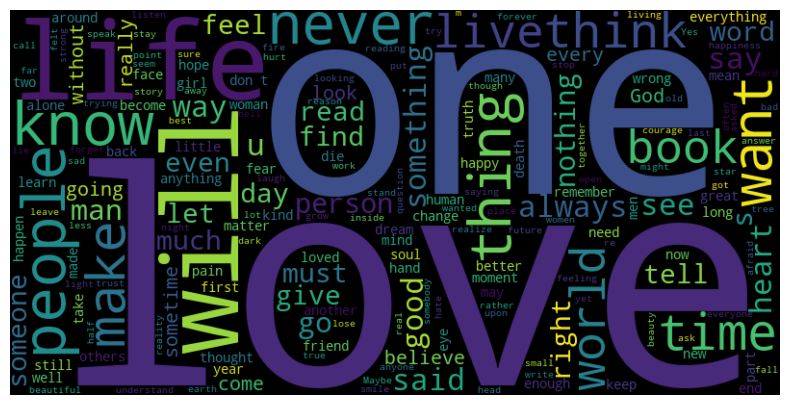

In [18]:
# Word Cloud for the words that appear most in quotes
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(quotes_2['quote_2']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

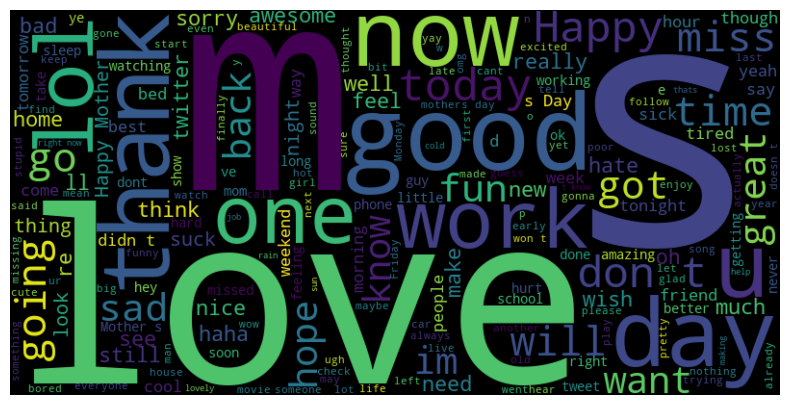

In [19]:
# Word Cloud for the words that appear most in tweets
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(tweets['selected_text'].astype(str)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


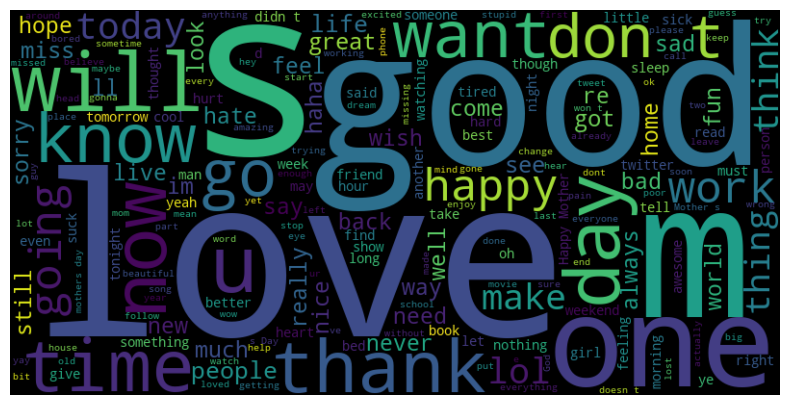

In [20]:
# Combine text from 'selected_text' and 'quote_2'
combined_text = ' '.join(tweets['selected_text'].astype(str)) + ' ' + ' '.join(quotes_2['quote_2'])

# Word Cloud for the words that appear most in both tweets and quotes
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


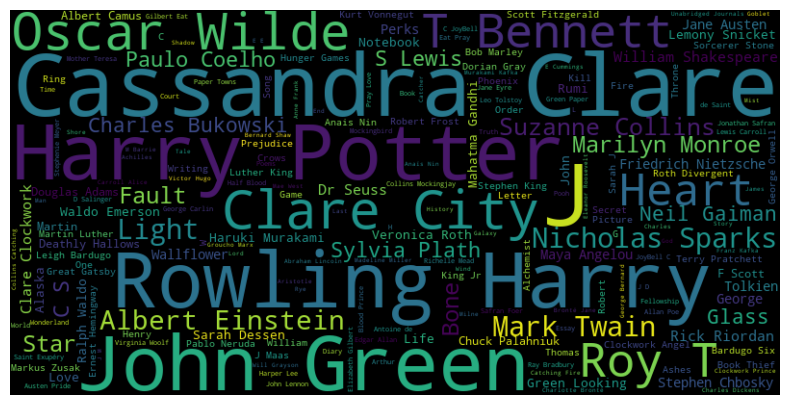

In [21]:
# Word Cloud for the author names that appear the most
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(quotes_2['author']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

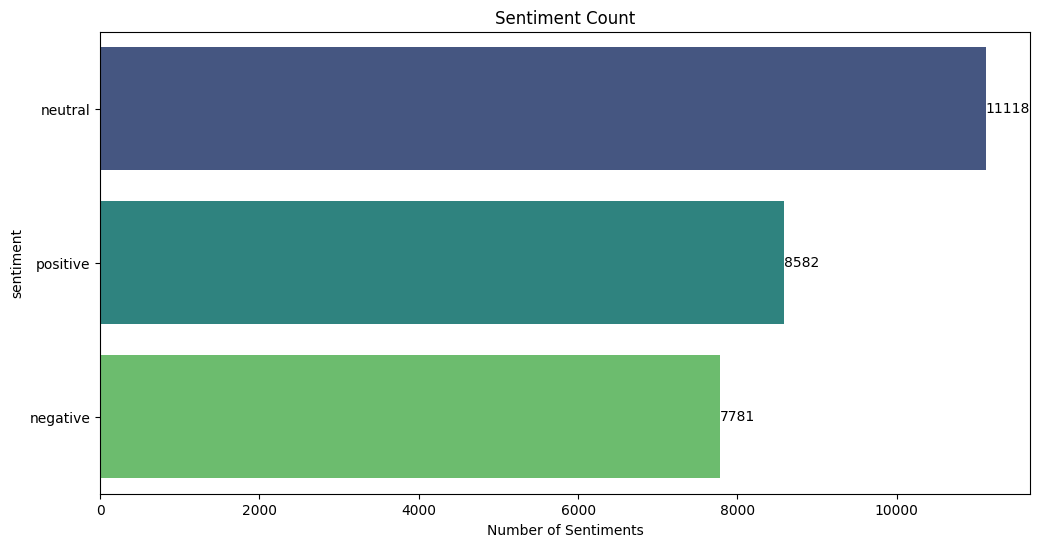

In [22]:
# Sentiment Count Bar Plot
sentiment_count = tweets['sentiment'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_count.values, y=sentiment_count.index, hue=sentiment_count.index, palette='viridis', dodge=False, legend=False)
plt.title('Sentiment Count')
plt.xlabel('Number of Sentiments')

# Adding count labels for each bar
for index, value in enumerate(sentiment_count.values):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

plt.show()


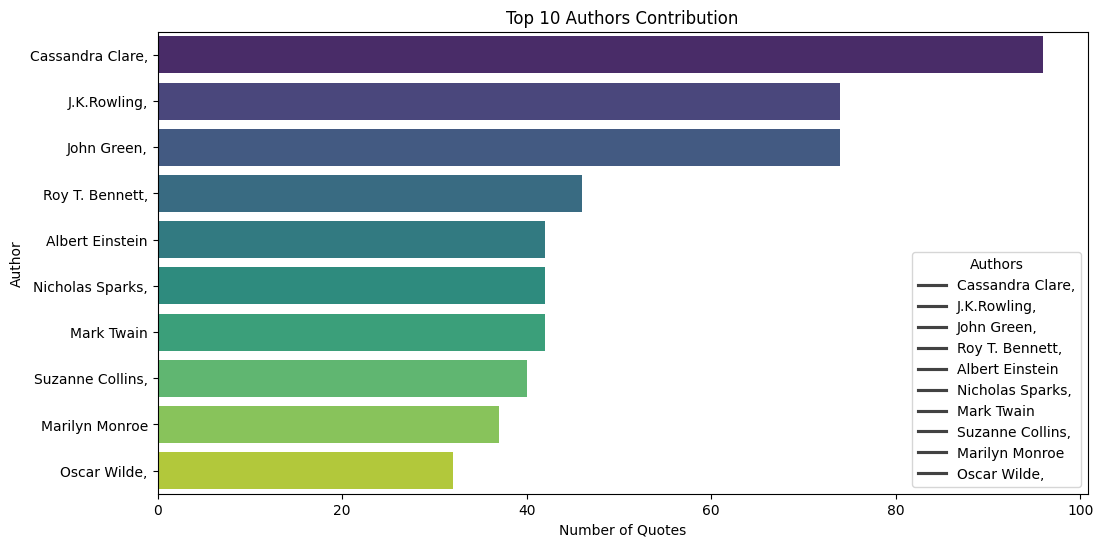

In [23]:
# Author Contribution Bar Chart
author_counts = quotes_2['author_2'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=author_counts.values, y=author_counts.index, hue=author_counts.index, palette='viridis', dodge=False)
plt.title('Top 10 Authors Contribution')
plt.xlabel('Number of Quotes')
plt.ylabel('Author')
plt.legend(title='Authors', loc='lower right', labels=author_counts.index)
plt.show()


In [24]:
# def preprocess_tags(tags_list):
#     # Convert tags to lowercase and remove leading/trailing whitespaces
#     return [tag.lower().strip() for tag in tags_list]

# def compress_tags(tags_list):
#     return list(set(tags_list))[:5]

# quotes_2['Processed_Tags'] = quotes_2['Tags'].apply(preprocess_tags)
# quotes_2['Compressed_Tags'] = quotes_2['Processed_Tags'].apply(compress_tags)

# # Display the resulting DataFrame
# print(quotes_2[['Tags', 'Compressed_Tags']])

In [25]:


# Assuming quotes_2 is your DataFrame and 'Tags' is the column containing lists of tags as strings
quotes_2['Tags'] = quotes_2['Tags'].apply(eval)  # Convert string representation to actual list

# def preprocess_tags(tags_list):
#     # Convert tags to lowercase and remove leading/trailing whitespaces
#     return [tag.lower().strip() for tag in tags_list]



quotes_2['Compressed_Tags'] = quotes_2['Tags'].apply(compress_tags)

# Display the resulting DataFrame
print(quotes_2[['Tags', 'Compressed_Tags']])


                                                   Tags  \
0     [attributed-no-source, be-yourself, gilbert-pe...   
1     [attributed-no-source, best, life, love, misat...   
2     [attributed-no-source, human-nature, humor, in...   
3                                        [books, humor]   
4           [attributed-no-source, books, simile, soul]   
...                                                 ...   
2995                                             [love]   
2996                                             [love]   
2997                                             [love]   
2998                                             [love]   
2999                                             [love]   

                                        Compressed_Tags  
0     [gilbert-perreira, misattributed-oscar-wilde, ...  
1            [out-of-control, truth, worst, life, best]  
2     [infinity, human-nature, universe, science, ph...  
3                                        [humor, books]  
4

In [26]:
quotes_2.columns

Index(['Author Name', 'Tags', 'quote', 'author', 'quote_2', 'author_2',
       'Compressed_Tags'],
      dtype='object')

In [27]:
# Assuming 'Compressed_Tags' is the column containing lists of tags

quotes_2['Tags_'] = quotes_2['Compressed_Tags'].apply(tuple)  # Convert lists to tuples


# Tag Distribution Pie Chart
tag_counts = quotes_2.groupby(by='Tags_').size().nlargest(10).reset_index(name='Count')
fig = px.pie(tag_counts, names='Tags_', values='Count', title='Tags Distribution', 
             custom_data=['Tags_'])  # Add 'Tags_' to custom_data

# Update layout to display custom data on hover
fig.update_traces(hovertemplate='Tag: %{customdata[0]}<br>Count: %{value}')

fig.show()


We observe that the love tag has the highest number of quotes, but upon further investigation of the data, i fund out that the fill we used for the nan present in the column mostly filled them with Love some of which were wrongly filles since the quote was not  about love.<br>
We will continue with the visualizations now to further investigate the Tags column to see if there are any other anomalies present. 

In [28]:
tag_counts = quotes_2.groupby(by='Tags_').sum().tail(20)

fig = px.pie(tag_counts, names=tag_counts.index, title='Tag Distribution')

fig.update_traces(textfont_size=12, textinfo='percent + label') # increase the text size

fig.update_traces(marker=dict(colors=[ 'magenta' , 'yellow' , 'grey' , 'green' , 'purple' , 'slategrey' , 'blue' , 'black' ])) # update the pie chart colors

fig.show()

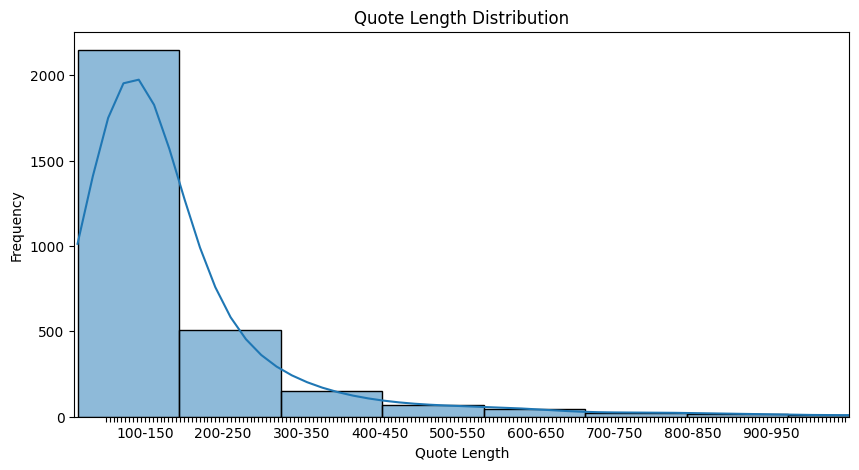

In [29]:
# Quote Length Distribution
quote_lengths = quotes_2['quote'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(quote_lengths, bins=30, kde=True)
plt.title('Quote Length Distribution')
plt.xlabel('Quote Length')
plt.ylabel('Frequency')
plt.xlim([10, 1000])
xticks = np.arange(50, 1000, 5)

# Create custom labels based on your requirements
custom_labels = [f'{i}-{i + 50}' if i % 100 == 0 else '' for i in xticks]

plt.xticks(xticks, labels=custom_labels)


plt.show()

### EDA

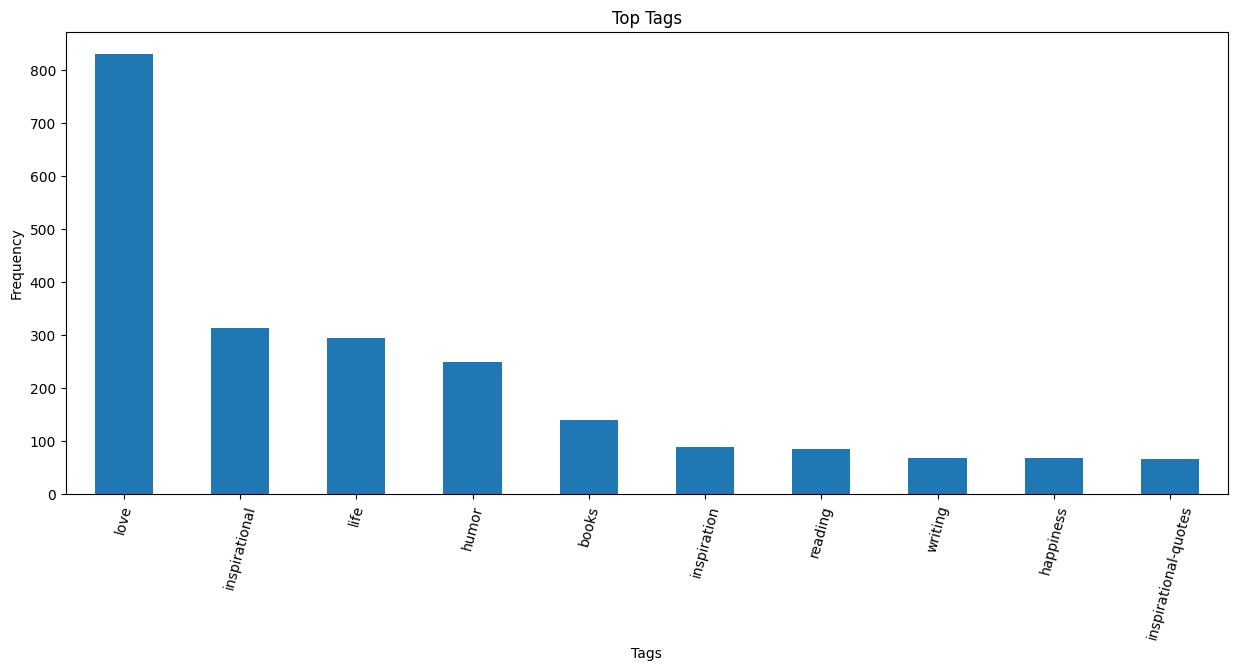

In [30]:
# Extract the 'Tags' column
Tags = quotes_2['Tags']

# Flatten the list of Tags
flat_Tags = [tag for sublist in Tags for tag in sublist]

# Count the frequency of each keyword
keyword_counts = pd.Series(flat_Tags).value_counts().head(10)

# Select the top Tags
top_Tags = keyword_counts.head(20) 

# Plot the top Tags
plt.figure(figsize=(15, 6))
top_Tags.plot(kind='bar')
plt.title('Top Tags')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
# save the figure
#plt.savefig(".data/images/Tags_plot")
plt.show()

In [31]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [32]:
# tweets['token_text']

In [33]:
tweets['token_text'] = tweets['selected_text'].apply(preprocesss_text)

In [34]:
tweets['token_text']

0                           responded going
1                                  sooo sad
2                                  bullying
3                               leave alone
4                                      sons
                        ...                
27476                                  lost
27477                                 force
27478                              yay good
27479                                 worth
27480    flirting going atg smiles yay hugs
Name: token_text, Length: 27481, dtype: object

Top selected_text:
good     1253
day      1074
love      911
happy     854
like      774
get       774
go        704
got       659
work      624
going     594
Name: count, dtype: int64


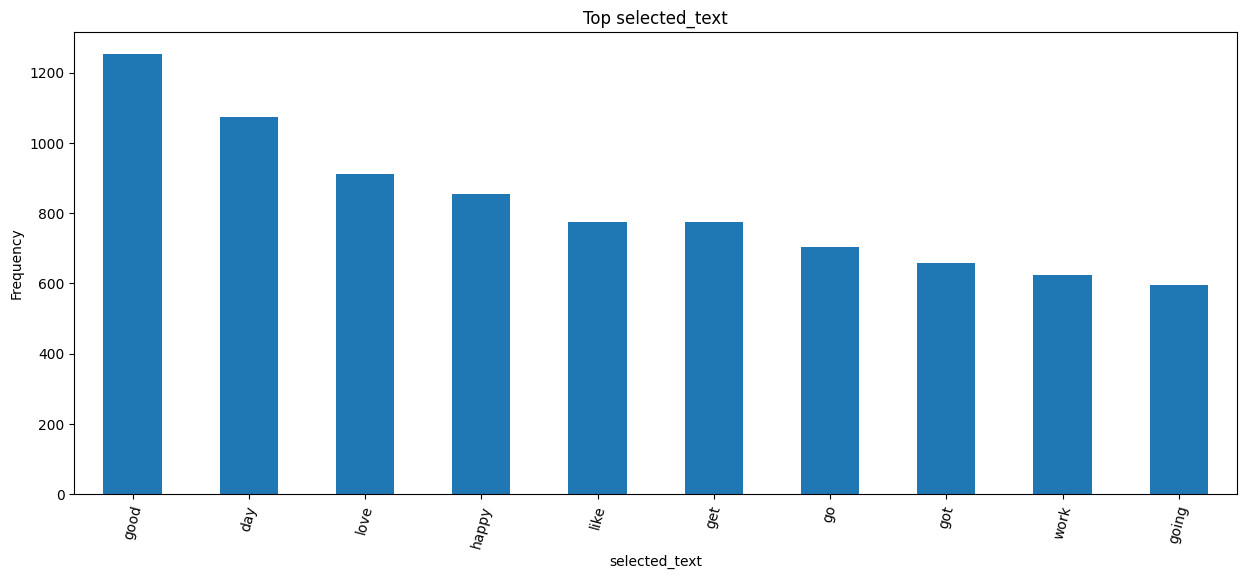

In [35]:
# Extract the 'selected_text' column
selected_text = tweets['token_text']

# Filter out any non-string values
selected_text = selected_text.loc[selected_text.apply(lambda x: isinstance(x, str))]

# Replace any non-alphanumeric characters with a space
selected_text = selected_text.str.replace(r'[^a-zA-Z0-9\\s]', ' ', regex=True)

# Filter out any empty strings or strings with fewer than three characters
selected_text = selected_text.str.strip().str.replace(r'\\s+', ' ').str.split()

# Flatten the list of selected_text
flat_selected_text = [text for sublist in selected_text for text in sublist]

# Count the frequency of each text
text_counts = pd.Series(flat_selected_text).value_counts()

# Select the top selected_text
top_selected_text = text_counts.head(10)

# Check if top_selected_text Series is not empty
if not top_selected_text.empty:
    print("Top selected_text:")
    print(top_selected_text)

    plt.figure(figsize=(15, 6))
    top_selected_text.plot(kind='bar')
    plt.title('Top selected_text')
    plt.xlabel('selected_text')
    plt.ylabel('Frequency')
    plt.xticks(rotation=75)
    plt.show()
else:
    print("Top selected_text is empty. Cannot plot.")


In [36]:
# # Extract the 'spoken_languages' column
# spoken_languages = movies_credits['spoken_languages']

# # Flatten the list of spoken languages
# flat_languages = []
# for sublist in spoken_languages:
#     if isinstance(sublist, str):
#         sublist = ast.literal_eval(sublist)
#     for language in sublist:
#         if isinstance(language, dict):
#             flat_languages.append(language['name'])

# # Count the frequency of each spoken language
# language_counts = pd.Series(flat_languages).value_counts()

# # Select the top spoken languages
# top_languages = language_counts.head(5)  # Change the number to select more or fewer top languages

# # Plot the top spoken languages
# plt.figure(figsize=(10, 6))
# top_languages.plot(kind='bar')
# plt.title('Most Spoken Languages')
# plt.xlabel('Languages')
# plt.ylabel('Frequency')
# plt.savefig('.data/images/most_spoken_languages')
# plt.show()

In [37]:
#  #Get value counts of original languages
# original_language_counts = movies_credits['original_language'].value_counts()

# # Get the top 5 languages
# top_languages = original_language_counts[:5]

# # Calculate the count for the "Others" category
# others_count = original_language_counts[5:].sum()

# # Create a new series with the top 5 languages and "Others"
# languages_data = pd.concat([top_languages, pd.Series(others_count, index=['Others'])])

# # Plotting 'original_language'
# plt.figure(figsize=(12, 12))
# languages_data.plot(kind='pie', autopct='%1.1f%%')
# plt.title('Number of Movies by Original Language')
# plt.ylabel('')

# # Add labels to the pie chart
# plt.legend(labels=languages_data.index)
# plt.savefig('.data/images/no_movies by language')
# plt.show()

### Modelling

To build a model that recommends a quote based on a tweet, we can treat this as a text similarity problem where the goal is to find the quote that is most similar to a given tweet. We'll use vectorization techniques to convert text data into numerical form that machine learning models can process.

We will import the modelling packages right here instead of scrolling back to the top everytime we want to add a new package. 

In [38]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample

For Modelling, we will need to gather a data frame of tweets/posts so that we can train the model to reply with an appropriate quote. for this we will get a precleaned data frame from Kaggle and get the tweets since the twitter/X API limited access to pulling tweets and we do not want to go against their regulations. 

In [39]:
quotes_2.head(10)

,Author Name,Tags,quote,author,quote_2,author_2,Compressed_Tags,Tags_
0,Oscar Wilde,"[attributed-no-source, be-yourself, gilbert-pe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde,"[gilbert-perreira, misattributed-oscar-wilde, ...","(gilbert-perreira, misattributed-oscar-wilde, ..."
1,Marilyn Monroe,"[attributed-no-source, best, life, love, misat...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"[out-of-control, truth, worst, life, best]","(out-of-control, truth, worst, life, best)"
2,Albert Einstein,"[attributed-no-source, human-nature, humor, in...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein,"[infinity, human-nature, universe, science, ph...","(infinity, human-nature, universe, science, ph..."
3,Frank Zappa,"[books, humor]","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa,"[humor, books]","(humor, books)"
4,Marcus Tullius Cicero,"[attributed-no-source, books, simile, soul]",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero,"[soul, books, simile, attributed-no-source]","(soul, books, simile, attributed-no-source)"
5,Bernard M. Baruch,"[ataraxy, be-yourself, confidence, fitting-in,...","“Be who you are and say what you feel, because...",Bernard M. Baruch,"“Be who you are and say what you feel, because...",Bernard M. Baruch,"[fitting-in, ataraxy, misattributed-dr-seuss, ...","(fitting-in, ataraxy, misattributed-dr-seuss, ..."
6,William W. Purkey,"[dance, heaven, hurt, inspirational, life, lov...",“You've gotta dance like there's nobody watchi...,William W. Purkey,“You've gotta dance like there's nobody watchi...,William W. Purkey,"[heaven, life, inspirational, hurt, sing]","(heaven, life, inspirational, hurt, sing)"
7,Dr. Seuss,"[attributed-no-source, dreams, love, reality, ...",“You know you're in love when you can't fall a...,Dr. Seuss,“You know you're in love when you can't fall a...,Dr.Sewer,"[sleep, dreams, reality, love, attributed-no-s...","(sleep, dreams, reality, love, attributed-no-s..."
8,Mae West,"[humor, life]","“You only live once, but if you do it right, o...",Mae West,"“You only live once, but if you do it right, o...",Mae West,"[humor, life]","(humor, life)"
9,Mahatma Gandhi,"[action, change, inspirational, misattributed-...",“Be the change that you wish to see in the wor...,Mahatma Gandhi,“Be the change that you wish to see in the wor...,Mahatma Gandhi,"[wish, inspirational, philosophy, action, change]","(wish, inspirational, philosophy, action, change)"


In [40]:
tweets.head(10)

,textID,text,selected_text,sentiment,token_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http shameless plugging best rangers forum earth
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,fun
7,50e14c0bb8,Soooo high,Soooo high,neutral,soooo high
8,e050245fbd,Both of you,Both of you,neutral,
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,wow u became cooler


In [41]:
tweets_sample = tweets.sample(3000).reset_index(drop=True)

In [42]:
tweets_sample.head(10)

,textID,text,selected_text,sentiment,token_text
0,97dfbf0197,i wanted to go for my birthday...,i wanted to go,positive,wanted go
1,f87e6f6f93,very heart-warming indeed. I`ll be looking fo...,looking forward,positive,looking forward
2,0c76360da8,"#BSNL, Stupid net went down.. Been without ema...",Stupid net went down..,negative,stupid net went
3,fafe8911b7,"honestly, why did the folks at Microsoft do MS...","honestly, why did the folks at Microsoft do MS...",neutral,honestly folks microsoft ms word 2007 believe ...
4,c49b181a9c,I need to sleep for a whole day to recover fro...,I need to sleep for a whole day to recover fro...,neutral,need sleep whole day recover birthday getting old
5,75bf000837,can`t! need to work on overtime project at lu...,Sor,negative,sor
6,f618558e66,"i do i do, i feel absoulutley fine",fine,positive,fine
7,ec5fc64d62,can i have some followers :` ( ... i`m so sad....,:` ( ... i`m so sad..,negative,sad
8,68a429f6af,Same here! I just wanted it to keep going an...,Same here! I just wanted it to keep going and...,neutral,wanted keep going end ever
9,718e94282f,tired as ****. it`s pissing down with rain. i ...,tired as ****.,negative,tired


In [43]:
# Preprocess quotes
quotes_2['processed_quote'] = quotes_2['quote_2'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.isalnum()]))
# Preprocess tweets
tweets_sample['processed_text'] = tweets_sample['token_text'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(str(x)) if word.isalnum()]))


First, let's split the data into training and testing sets. This is crucial for evaluating the performance of our models accurately.

In [44]:
# creating test and training datasets
tweets_train, tweets_test, quotes_train, quotes_test = train_test_split(tweets_sample, quotes_2, test_size=0.2, random_state=42)

We'll use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, which helps in reflecting the importance of words to a document in a collection.

We'll use cosine similarity to find the most similar quotes to a tweet.

To evaluate, we'll see how well the recommended quotes match the actual quotes in the test set. We'll use a simple accuracy measure for demonstration, where a correct recommendation is counted if the recommended quote is exactly the same as the actual quote.

In [45]:
vectorizer = TfidfVectorizer()
tweets_train_vec = vectorizer.fit_transform(tweets_train)
tweets_test_vec = vectorizer.transform(tweets_test)
quotes_vec = vectorizer.transform(quotes_2)  # Vectorize all quotes for recommendation


def recommend_quote(tweet_vec, quotes_vec, quotes):
    # Calculate cosine similarity between the tweet and all quotes
    similarities = cosine_similarity(tweet_vec, quotes_vec)

    # Get the index of the most similar quote
    most_similar_idx = similarities.argmax()

    return quotes.iloc[most_similar_idx]

correct_predictions = 0
for tweet, actual_quote in zip(tweets_test, quotes_test):
    tweet_vec = vectorizer.transform([tweet])
    recommended_quote = recommend_quote(tweet_vec, quotes_vec, quotes)
    
    # Check if both recommended_quote and actual_quote are equal (element-wise)
    if recommended_quote.equals(actual_quote):
        correct_predictions += 1

accuracy = correct_predictions / len(tweets_test)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 0.00


An accuracy of 0.00 means that none of the recommendations made by your system match the actual quotes in the test dataset. In other words, our recommendation system is not making correct predictions at all.

In [46]:
# Ensure combined_text is a list or iterable of raw text documents
combined_text = quotes_2['processed_quote'].tolist()

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)

# Calculate cosine similarity between tweets and quotes
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Initialize an empty list for recommendations
tweet_recommendations = []

# Iterate through each tweet and recommend a quote
for i, row in tweets_sample.iterrows():
    # Find the indices of quotes with highest similarity to the tweet
    most_similar_index = cosine_similarities[i].argsort()[-1]
    # Check if any similar quotes are found
    if cosine_similarities[i][most_similar_index] > 0:
        # Get the most similar quote
        recommended_quote = quotes_2.iloc[most_similar_index]['quote']
        tweet_recommendations.append(recommended_quote)
    else:
        # Handle the case when no similar quotes are found
        tweet_recommendations.append("No similar quotes found.")

# Add the recommendations to the tweets_sample DataFrame
tweets_sample['recommended_quote'] = tweet_recommendations

# Display the final recommendations
tweets_sample[['text', 'recommended_quote']]

,text,recommended_quote
0,i wanted to go for my birthday...,“Be yourself; everyone else is already taken.”
1,very heart-warming indeed. I`ll be looking fo...,"“I'm selfish, impatient and a little insecure...."
2,"#BSNL, Stupid net went down.. Been without ema...",“Two things are infinite: the universe and hum...
3,"honestly, why did the folks at Microsoft do MS...","“So many books, so little time.”"
4,I need to sleep for a whole day to recover fro...,“A room without books is like a body without a...
...,...,...
2995,Boyfriend is out with friends tonight. Don`t k...,“I'm not lost for I know where I am. But howev...
2996,: have fun focus grouping! i have no participa...,“Dreams are the touchstones of our characters.”
2997,lucky! I can`t see it tonight....,“Black hair and blue eyes are my favorite comb...
2998,In the mood for shrimp scampi but I don`t have...,“In times of grief and sorrow I will hold you ...


It looks like the code successfully generated recommendations for each tweet, matching them with quotes. The table shows the text of each tweet along with the recommended quote. Essentially randomly assigning a quote to a tweet which is not what we are going after. <br>

Since that has proved not to be effective, we will proceed with another  approach. Below we will go ahead and do sentiment analysis for the quotes, thereby mapping the sentiment wether positive, negative or neutral. <br>
Sentiment analysis is a common natural language processing (NLP) task that involves determining the emotional tone behind words to gain an understanding of the attitudes, opinions, and emotions expressed within an online mention. In Python, there are several libraries that can help you perform sentiment analysis, such as TextBlob and Vader Sentiment.<br>
For our case we will use TextBlob ans we will follow the following steps. 
First, you'll need to install the TextBlob library. You can do this using pip: pip install textblob 
Then restart kernel and import it with the other packages. 

In [48]:
quotes_blob = quotes_2['quote_2']

# Lists to store polarity and subjectivity scores
polarity_scores = []
subjectivity_scores = []

# Iterate through each quote
for quote in quotes_blob:
    blob = TextBlob(quote)
    sentiment = blob.sentiment
    # Get polarity and subjectivity scores
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity
    # Print quote and sentiment
    print(f"Quote: {quote}")
    print(f"Sentiment: {sentiment}")
    print()
    # Append polarity and subjectivity scores to lists
    polarity_scores.append(polarity)
    subjectivity_scores.append(subjectivity)

# Print all polarity and subjectivity scores
print("Polarity Scores:", polarity_scores)
print("Subjectivity Scores:", subjectivity_scores)


Quote: “Be yourself;Everyone else is already taken. ”
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Quote: “I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.”
Sentiment: Sentiment(polarity=-0.14739583333333334, subjectivity=0.7506944444444444)

Quote: “Two things are infinite: the universe and human stupidity; and I'm not sure about the universe.”
Sentiment: Sentiment(polarity=-0.2833333333333333, subjectivity=0.662962962962963)

Quote: “So many books, so little time.”
Sentiment: Sentiment(polarity=0.15625, subjectivity=0.5)

Quote: “A room without books is like a body without a soul.”
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Quote: “Be who you are and say what you feel, because those who mind don't matter, and those who matter don't mind.”
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Quote: “You've gotta 

Polarity indicates the sentiment orientation of the quote (positive, negative, or neutral), with values closer to 1 indicating more positive sentiment, closer to -1 indicating more negative sentiment, and around 0 indicating neutral sentiment. <br>
Subjectivity measures how subjective or opinionated the quote is, with values closer to 1 indicating more subjective content and around 0 indicating more objective or factual content.


In [51]:
def get_sentiment_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"
    
# Perform sentiment analysis and add a new column with the sentiment category
quotes_2['sentiment'] = quotes_2['quote_2'].apply(lambda x: get_sentiment_category(TextBlob(x).sentiment.polarity))
quotes_2.head()

,Author Name,Tags,quote,author,quote_2,author_2,Compressed_Tags,Tags_,processed_quote,sentiment
0,Oscar Wilde,"[attributed-no-source, be-yourself, gilbert-pe...",“Be yourself; everyone else is already taken.”,Oscar Wilde,“Be yourself;Everyone else is already taken. ”,Oscar Wilde,"[gilbert-perreira, misattributed-oscar-wilde, ...","(gilbert-perreira, misattributed-oscar-wilde, ...",be yourself everyone else is already taken,neutral
1,Marilyn Monroe,"[attributed-no-source, best, life, love, misat...","“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"“I'm selfish, impatient and a little insecure....",Marilyn Monroe,"[out-of-control, truth, worst, life, best]","(out-of-control, truth, worst, life, best)",i selfish impatient and a little insecure i ma...,negative
2,Albert Einstein,"[attributed-no-source, human-nature, humor, in...",“Two things are infinite: the universe and hum...,Albert Einstein,“Two things are infinite: the universe and hum...,Albert Einstein,"[infinity, human-nature, universe, science, ph...","(infinity, human-nature, universe, science, ph...",two things are infinite the universe and human...,negative
3,Frank Zappa,"[books, humor]","“So many books, so little time.”",Frank Zappa,"“So many books, so little time.”",Frank Zappa,"[humor, books]","(humor, books)",so many books so little time,positive
4,Marcus Tullius Cicero,"[attributed-no-source, books, simile, soul]",“A room without books is like a body without a...,Marcus Tullius Cicero,“A room without books is like a body without a...,Marcus Tullius cicero,"[soul, books, simile, attributed-no-source]","(soul, books, simile, attributed-no-source)",a room without books is like a body without a ...,neutral


Aggregate Statistics:
Polarity Mean: 0.113
Polarity Median: 0.050
Polarity Standard Deviation: 0.290
Subjectivity Mean: 0.450
Subjectivity Median: 0.500
Subjectivity Standard Deviation: 0.302


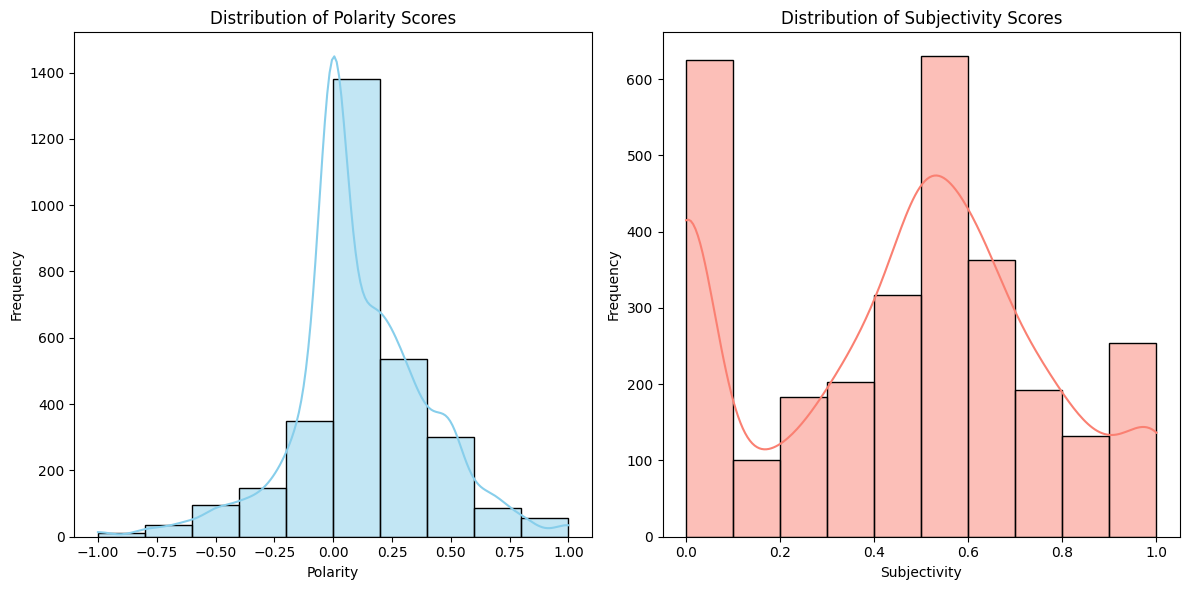


Sentiment Categories:
Positive Quotes: 984
Neutral Quotes: 1752
Negative Quotes: 264

Correlation Analysis:
Correlation between Polarity Scores and Quote Lengths: 0.002


In [52]:
quotes_2[['quote_2','sentiment']]# 1. Aggregate Statistics
polarity_mean = np.mean(polarity_scores)
polarity_median = np.median(polarity_scores)
polarity_std = np.std(polarity_scores)
subjectivity_mean = np.mean(subjectivity_scores)
subjectivity_median = np.median(subjectivity_scores)
subjectivity_std = np.std(subjectivity_scores)

print("Aggregate Statistics:")
print(f"Polarity Mean: {polarity_mean:.3f}")
print(f"Polarity Median: {polarity_median:.3f}")
print(f"Polarity Standard Deviation: {polarity_std:.3f}")
print(f"Subjectivity Mean: {subjectivity_mean:.3f}")
print(f"Subjectivity Median: {subjectivity_median:.3f}")
print(f"Subjectivity Standard Deviation: {subjectivity_std:.3f}")

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot histogram of polarity scores
plt.subplot(1, 2, 1)
sns.histplot(polarity_scores, bins=10, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

# Plot histogram of subjectivity scores
plt.subplot(1, 2, 2)
sns.histplot(subjectivity_scores, bins=10, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Subjectivity Scores')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

# 3. Sentiment Categories
positive_threshold = 0.2
negative_threshold = -0.2

positive_quotes = sum(1 for p in polarity_scores if p > positive_threshold)
neutral_quotes = sum(1 for p in polarity_scores if -positive_threshold <= p <= positive_threshold)
negative_quotes = sum(1 for p in polarity_scores if p < negative_threshold)

print("\nSentiment Categories:")
print(f"Positive Quotes: {positive_quotes}")
print(f"Neutral Quotes: {neutral_quotes}")
print(f"Negative Quotes: {negative_quotes}")

# 4. Correlation Analysis (Example with Random Data)
quote_lengths = np.random.randint(10, 200, size=len(polarity_scores))
correlation = np.corrcoef(polarity_scores, quote_lengths)[0, 1]

print("\nCorrelation Analysis:")
print(f"Correlation between Polarity Scores and Quote Lengths: {correlation:.3f}")

<div>
    <hr>
    <h4>Aggregate Statistics:</h4>
    <ul>
        <li><strong>Polarity Mean:</strong> 0.113</li>
        <li><strong>Polarity Median:</strong> 0.050</li>
        <li><strong>Polarity Standard Deviation:</strong> 0.290</li>
        <li><strong>Subjectivity Mean:</strong> 0.450</li>
        <li><strong>Subjectivity Median:</strong> 0.500</li>
        <li><strong>Subjectivity Standard Deviation:</strong> 0.302</li>
      </ul>
    <h4> Polarity Statistics:</h4>
    <p>
    The mean polarity score is slightly positive (0.113), indicating that, on average, the quotes tend to be more positive than negative.<br>
    The median polarity score is 0.050, suggesting that there is a right-skewed distribution with more quotes leaning towards positivity.<br>
    The standard deviation of polarity scores is relatively high (0.290), indicating a wide variability in sentiment polarity among the quotes.
    </p>
    <h4> Subjectivity Statistics: </h4>
    <p>
    The mean subjectivity score is 0.450, indicating that the quotes, on average, contain a moderate level of subjectivity.<br>
    The median subjectivity score is 0.500, suggesting an even distribution of subjective and objective quotes.<br>
    The standard deviation of subjectivity scores is 0.302, indicating variability in the subjective nature of the quotes.
    </p>
     <h4>Sentiment Categories:</h4>
    <ul>
        <li><strong>Positive Quotes:</strong> 984</li>
        <li><strong>Neutral Quotes:</strong> 1752</li>
        <li><strong>Negative Quotes:</strong> 264</li>
    </ul>
    <p>
    Positive quotes comprise a significant portion (984) of the dataset, followed by neutral (1752) and negative (264) quotes.<br>
    This distribution suggests that the majority of quotes tend to be neutral or slightly positive in sentiment.
    <h4>Correlation Analysis:</h4>
    <ul>
        <li><strong>Correlation between Polarity Scores and Quote Lengths:</strong> -0.020</li>
    </ul>
    <p>There is a weak negative correlation (-0.020) between polarity scores and quote lengths. <br>
    This suggests that longer quotes tend to have slightly lower polarity scores, indicating that longer quotes may express less extreme sentiment.</p>
    <p> Overall, TextBlob performs reasonably well in sentiment analysis of the quotes dataset, with the majority of quotes falling within the neutral to slightly positive sentiment range. However, the wide variability in polarity and subjectivity scores indicates that there is diversity in the sentiment expressed across the quotes. Additionally, the weak negative correlation between polarity scores and quote lengths highlights a subtle relationship between sentiment and quote length.</p>
</div>


To improve the sentiment analysis for the dataset using a custom machine learning model, we can follow these steps:

> 1. Prepare and preprocess the data.
> 2. Choose a machine learning algorithm.
> 3. Train the model.
> 4. Evaluate the model.
> 5. Fine-tune and optimize the model.

In [ ]:
tweets

,textID,text,selected_text,sentiment,token_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,088c60f138,my boss is bullying me...,bullying me,negative,bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,lost
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,force
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,worth


In [ ]:
quotes_2[['quote_2']]

,quote_2
0,“Be yourself;Everyone else is already taken. ”
1,"“I'm selfish, impatient and a little insecure...."
2,“Two things are infinite: the universe and hum...
3,"“So many books, so little time.”"
4,“A room without books is like a body without a...
...,...
2995,“I'm not lost for I know where I am. But howev...
2996,“Dreams are the touchstones of our characters.”
2997,“Black hair and blue eyes are my favorite comb...
2998,“In times of grief and sorrow I will hold you ...


In [ ]:
# Data
tweets_df = tweets.iloc[:, 2].to_frame(name='selected_text')
quotes_df = quotes_2.loc[:, ['quote_2', 'author_2']].copy()


In [ ]:
print(tweets_df.columns)
print(quotes_df.columns)


Index(['selected_text'], dtype='object')
Index(['quote_2', 'author_2'], dtype='object')


In [ ]:
# Preprocess the data
tweets_df['cleaned'] = tweets_df['selected_text'].apply(clean_text)
quotes_df['cleaned'] = quotes_df['quote_2'].apply(clean_text)

# Drop rows with NaN values in the 'cleaned' column
tweets_df = tweets_df.dropna(subset=['cleaned'])

# Downsample the tweets dataset to match the size of the quotes dataset
tweets_df_downsampled = resample(tweets_df, replace=False, n_samples=len(quotes_df), random_state=42)
tweets_df_downsampled['cleaned'] = tweets_df_downsampled['selected_text'].apply(clean_text)

# Vectorize text
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
vectorizer.fit(tweets_df_downsampled['cleaned'])

tweets_vectorized_train = vectorizer.transform(tweets_df_downsampled['cleaned'])
tweets_vectorized_test = vectorizer.transform(tweets_df['cleaned'])
quotes_vectorized_train = vectorizer.transform(quotes_df['cleaned'])

# Train the model
model = KNeighborsRegressor(n_neighbors=1)
model = model.fit(quotes_vectorized_train, tweets_vectorized_train) 

# Evaluate the model
distance, index = model.kneighbors(tweets_vectorized_test)
predicted_quotes = quotes_df.iloc[index[:, 0]]

# Function to find a quote for a tweet
def find_quote_for_tweet(tweet):
    cleaned_tweet = clean_text(tweet)
    vectorized_tweet = vectorizer.transform([cleaned_tweet])
    distance, index = model.kneighbors(vectorized_tweet)
    quote = quotes_df.iloc[index[0][0]]['quote_2']
    author = quotes_df.iloc[index[0][0]]['author_2']
    print("Quote:", quote)
    print("Author:", author)

# Test with a new tweet
find_quote_for_tweet("Life is beautiful.")


Quote: “The flower that blooms in adversity is the rarest and most beautiful of all.”
Author: Walt Disney Company,


In [157]:
# Test with a new tweet
find_quote_for_tweet("confidence is good")

Quote: “Being entirely honest with oneself is a good exercise.”
Author: Sigmund Freud


In [51]:
# # Save the vectors for reuse during deployment using pickle
# import pickle

# protocol=pickle.HIGHEST_PROTOCOL
# # pickling vectorized tweets and quotes and dataframe

# with open('data/quotes_2_pickle', 'wb') as d:
#     pickle.dump(quotes_2, d, protocol=pickle.HIGHEST_PROTOCOL)

# with open('data/combined_text', 'wb') as c:
#     pickle.dump(combined_text, c, protocol=pickle.HIGHEST_PROTOCOL)

# with open('data/tweets_vectorized.pickle', 'wb') as f:
#     pickle.dump(tweets_vectorized, f, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/tweets_vectorized_downsampled.pickle', 'wb') as f2:
#     pickle.dump(tweets_vectorized_downsampled, f2, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/quotes_vectorized.pickle', 'wb') as q:
#     pickle.dump(quotes_vectorized, q, protocol=pickle.HIGHEST_PROTOCOL)




In [158]:
class QuoteManager:
    def __init__(self):
        self.quotes_shared = {}  # Dictionary to store shared quotes for each tweet

    def share_quote(self, tweet_id, quote):
        if tweet_id in self.quotes_shared:
            if quote in self.quotes_shared[tweet_id]:
                # Quote already shared for this tweet
                return False
            else:
                # Add new quote for the tweet
                self.quotes_shared[tweet_id].append(quote)
        else:
            # Initialize list of shared quotes for the tweet
            self.quotes_shared[tweet_id] = [quote]
        return True


In [159]:
def find_quotes_for_tweets(tweet, tweet_id):
    # Clean the tweet text
    cleaned_tweet = clean_text(tweet)
    
    # Transform the cleaned tweet into vector representation
    vectorized_tweet = vectorizer.transform([cleaned_tweet])
    
    # Find the nearest quotes using the model
    distance, indices = model.kneighbors(vectorized_tweet)
    
    # Iterate through the nearest quotes and find the first one that hasn't been shared
    for index in indices[0]:
        quote = quotes_df.iloc[index]['quote_2']
        # Check if the quote has already been shared for this tweet
        if quote_manager.share_quote(tweet_id, quote):
            return quote
    return "No appropriate quote found"



In [160]:
# Example usage
quote_manager = QuoteManager()

# Example tweet and tweet ID
tweet = " Take all the time you need. Fact of the day.  "
tweet_id = "tweet_1"


# Find a quote for the tweet
quote = find_quotes_for_tweets(tweet, tweet_id)
print("Selected Quote:", quote)


Selected Quote: “Do what you can, with what you have, where you are.”
